In [4]:
import numpy as np
import pandas as pd
import scipy.stats

pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt, rcParams
# import cv2
import seaborn as sns

sns.set(style="white", context="paper")
from cycler import cycler
import os, sys
import glob
from datetime import datetime, timedelta
from itertools import combinations, product
import base64
from PIL import Image
from io import BytesIO as _BytesIO
import requests
import json
import pickle
from datetime import datetime
from IPython.display import display, Markdown, Latex
from sklearn.metrics import *
import collections
from copy import deepcopy
import traceback
from sympy import Point, Polygon
from decorators import *
from smartprint import smartprint as sprint
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
import mmcv
from mmtrack.apis import inference_mot, init_model as init_tracking_model
# import plotly
# from pandas_profiling import ProfileReport

pd.options.display.max_columns = None
def printm(s): return display(Markdown(s))
    
SERVER_CACHE_DIR = '/mnt/ci-nas-cache/edulyzeV2/cache_compute_4/fixed_face'
os.makedirs(SERVER_CACHE_DIR,exist_ok=True)

track_analysis_meta_cache = f'{SERVER_CACHE_DIR}/analysis_tracking/meta_info'
base_dir = '/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face/'

track_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_tracking/session_tracking_info'
os.makedirs(track_analysis_session_data,exist_ok=True)

postprocessed_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/processed_id_maps'
os.makedirs(postprocessed_id_map_data_dir, exist_ok=True)

emb_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_emb/session_emb_info_new'
os.makedirs(emb_analysis_session_data,exist_ok=True)

embmatched_id_raw_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/embmatched_id_raw'
os.makedirs(embmatched_id_raw_data_dir,exist_ok=True)

embmatched_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/embmatched_id_maps'
os.makedirs(embmatched_id_map_data_dir, exist_ok=True)

cross_session_input_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/cross_session_input'
os.makedirs(cross_session_input_data_dir, exist_ok=True)

id_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_emb/session_matching_info'
os.makedirs(id_viz_cache_root, exist_ok=True)

/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


## Get frame file data for all sessions

In [5]:

frame_file_data = {}
for course_idx, course_dir in enumerate(glob.glob(f"{base_dir}/*")):
    course_name = course_dir.split("/")[-1]
    course_cache_file = f"{track_analysis_meta_cache}/{course_name}"
    if os.path.exists(course_cache_file):
        frame_file_data[course_name] = pickle.load(open(course_cache_file,"rb"))
        continue
    frame_file_data[course_name]={}
        
    for session_idx, session_dir in enumerate(glob.glob(f"{course_dir}/*")):
        session_name = session_dir.split("/")[-1]
        frame_file_data[course_name][session_name] = {}
        frame_files = glob.glob(f"{session_dir}/*")
        frame_file_names = [xr.split("/")[-1] for xr in frame_files]
        if 'end.pb' in frame_file_names:
            frame_file_data[course_name][session_name]['is_completed']=True
        else:
            frame_file_data[course_name][session_name]['is_completed']=False            
        frame_ids = [int(xr.split(".")[0]) for xr in frame_file_names if not (xr=='end.pb')]
        frame_file_data[course_name][session_name]['frame_ids'] = sorted(frame_ids)
        frame_file_data[course_name][session_name]['dir_location'] = session_dir
        print(f"Got metadata for course: {course_idx}-{course_name}, session:{session_idx}-{session_name}")
    pickle.dump(frame_file_data[course_name],open(course_cache_file,"wb")) 
        
frame_file_data.keys()

dict_keys(['05748A', '05410B', '17214C', '17214B', '05681A', '24352A', '24352C', '86375A'])

In [6]:
session_filter_list = ['classinsight-cmu_05681A_ghc_4301_201905011630',
 'classinsight-cmu_05681A_ghc_4301_201904171630',
 'classinsight-cmu_05681A_ghc_4301_201902201630',
 'classinsight-cmu_05681A_ghc_4301_201904101630',
 'classinsight-cmu_05681A_ghc_4301_201901231630',
                       
 'classinsight-cmu_05418A_ghc_4102_201902251200',
 'classinsight-cmu_05418A_ghc_4102_201904081200',
 'classinsight-cmu_05418A_ghc_4102_201905011200',
 'classinsight-cmu_05418A_ghc_4102_201904291200',
 'classinsight-cmu_05418A_ghc_4102_201904011200',
                       
 'classinsight-cmu_05748A_ghc_4101_201902141630',
 'classinsight-cmu_05748A_ghc_4101_201904021630',
 'classinsight-cmu_05748A_ghc_4101_201902051630',
 'classinsight-cmu_05748A_ghc_4101_201902281630',
 'classinsight-cmu_05748A_ghc_4101_201903071630',
                       
 'classinsight-cmu_21127J_ghc_4102_201904230930',
 'classinsight-cmu_21127J_ghc_4102_201903260930',
 'classinsight-cmu_21127J_ghc_4102_201904160930',
 'classinsight-cmu_21127J_ghc_4102_201904300930',
 'classinsight-cmu_21127J_ghc_4102_201903190930',
                       
 'classinsight-cmu_05410A_ghc_4301_201904151500',
 'classinsight-cmu_05410A_ghc_4301_201902251500',
 'classinsight-cmu_05410A_ghc_4301_201904081500',
 'classinsight-cmu_05410A_ghc_4301_201904221500',
 'classinsight-cmu_05410A_ghc_4301_201902181500',
                       
 'classinsight-cmu_17214B_ph_a21_201902271030',
 'classinsight-cmu_17214B_ph_a21_201903061030',
 'classinsight-cmu_17214B_ph_a21_201904031030',
 'classinsight-cmu_17214B_ph_a21_201904101030',
 'classinsight-cmu_17214B_ph_a21_201904241030',
                       
 'classinsight-cmu_17214C_ph_225b_201904031130',
 'classinsight-cmu_17214C_ph_225b_201904101130',
 'classinsight-cmu_17214C_ph_225b_201904171130',
 'classinsight-cmu_17214C_ph_225b_201904241130',
 'classinsight-cmu_17214C_ph_225b_201905011130',
                       
 'classinsight-cmu_05410B_ghc_4211_201902111500',
 'classinsight-cmu_05410B_ghc_4211_201903181500',
 'classinsight-cmu_05410B_ghc_4211_201904081500',
 'classinsight-cmu_05410B_ghc_4211_201904151500',
 'classinsight-cmu_05410B_ghc_4211_201904221500',
 'classinsight-cmu_05410B_ghc_4211_201901281500'
]

# Get vizualization for single session

In [7]:
sample_course = '05410B'
sample_session_id = 'classinsight-cmu_05410B_ghc_4211_201904151500-front'
session_tracking_cache_file = f"{track_analysis_session_data}/{sample_session_id}.pb"
session_preprocessed_id_map_file = f"{postprocessed_id_map_data_dir}/{sample_session_id}.pb"
session_frame_dir = f'{base_dir}/{sample_course}/{sample_session_id}'
session_video_file = f'/mnt/ci-nas-classes/classinsight/2019S/video_backup/{sample_session_id.split("-front")[0]}/{sample_session_id}.avi'
session_frame_dir

'/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face//05410B/classinsight-cmu_05410B_ghc_4211_201904151500-front'

In [8]:
old_to_new_id_map = pickle.load(open(session_preprocessed_id_map_file,"rb"))
df_session_eligible_pairs = pd.read_csv(f"{embmatched_id_map_data_dir}/{sample_session_id}.csv")
# Correct new ids with dict from eligible pairs
eligible_id_map_dict = {}
for id_pair in df_session_eligible_pairs.id_pair.values:
    (id1, id2) = eval(id_pair)
    print(id1, id2)
    if id2 in eligible_id_map_dict:
        eligible_id_map_dict[id1] = eligible_id_map_dict[id2]
    else:
        eligible_id_map_dict[id2] = id1

sprint(eligible_id_map_dict)

# correct created eligible map for once more
for key in sorted(list(eligible_id_map_dict.keys())):
    key_value = eligible_id_map_dict[key]
    if key_value in eligible_id_map_dict.keys():
        eligible_id_map_dict[key] = eligible_id_map_dict[key_value]
sprint(eligible_id_map_dict) 
# sprint({kr:old_to_new_id_map[kr] for kr in old_to_new_id_map if (not old_to_new_id_map[kr]==10000)}) 
sprint("replacing ids in old to new id maps")
for old_id in old_to_new_id_map:
    if old_to_new_id_map[old_id] in eligible_id_map_dict:
        print(f"replacing {old_id}:{old_to_new_id_map[old_id]} -->{eligible_id_map_dict[old_to_new_id_map[old_id]]}")
        old_to_new_id_map[old_id] = eligible_id_map_dict[old_to_new_id_map[old_id]]
# sprint({kr:old_to_new_id_map[kr] for kr in old_to_new_id_map if (not old_to_new_id_map[kr]==10000)}) 


0 30
11 19
12 20
26 28
Dict: eligible_id_map_dict
Key: Value


{19: 11, 20: 12, 28: 26, 30: 0}

Dict: eligible_id_map_dict
Key: Value


{19: 11, 20: 12, 28: 26, 30: 0}

"replacing ids in old to new id maps" : replacing ids in old to new id maps
replacing 915:19 -->11
replacing 933:20 -->12
replacing 1291:28 -->26
replacing 1346:30 -->0


In [9]:
# map processed ids to tracking df
df_tracking_new = pickle.load(open(session_tracking_cache_file,"rb")).transpose()
total_idxs = df_tracking_new.index.max()
for old_id in old_to_new_id_map:
    new_id = old_to_new_id_map[old_id]
    if not new_id==10000:
        new_id_col = f'N{new_id}'
        if new_id_col not in df_tracking_new:
            df_tracking_new[new_id_col] = None
        df_tracking_new[new_id_col] =  df_tracking_new[old_id].where(~df_tracking_new[old_id].isnull(), df_tracking_new[old_id])
    df_tracking_new = df_tracking_new.drop(old_id, axis=1)




In [10]:
col_start_stop_idxs = []
for col in df_tracking_new.columns:
    one_idxs = df_tracking_new.index[np.where(df_tracking_new[col]==1)[0]].values
    col_start_stop_idxs.append([col, one_idxs.min(), one_idxs.max()])
df_id_start_stop = pd.DataFrame(col_start_stop_idxs, columns=['id','min_idx','max_idx'])
df_id_start_stop['total_idxs'] = df_id_start_stop['max_idx']-df_id_start_stop['min_idx']
df_id_start_stop['id'] = df_id_start_stop['id'].apply(lambda x: int(x[1:]))
df_id_start_stop

,id,min_idx,max_idx,total_idxs
0,0,54438,58569,4131
1,1,54783,71592,16809
2,2,0,70536,70536
3,3,58995,68364,9369
4,4,34779,54480,19701
5,5,381,1689,1308
6,6,61791,71835,10044
7,7,68535,71988,3453
8,8,1704,54462,52758
9,9,66795,71988,5193


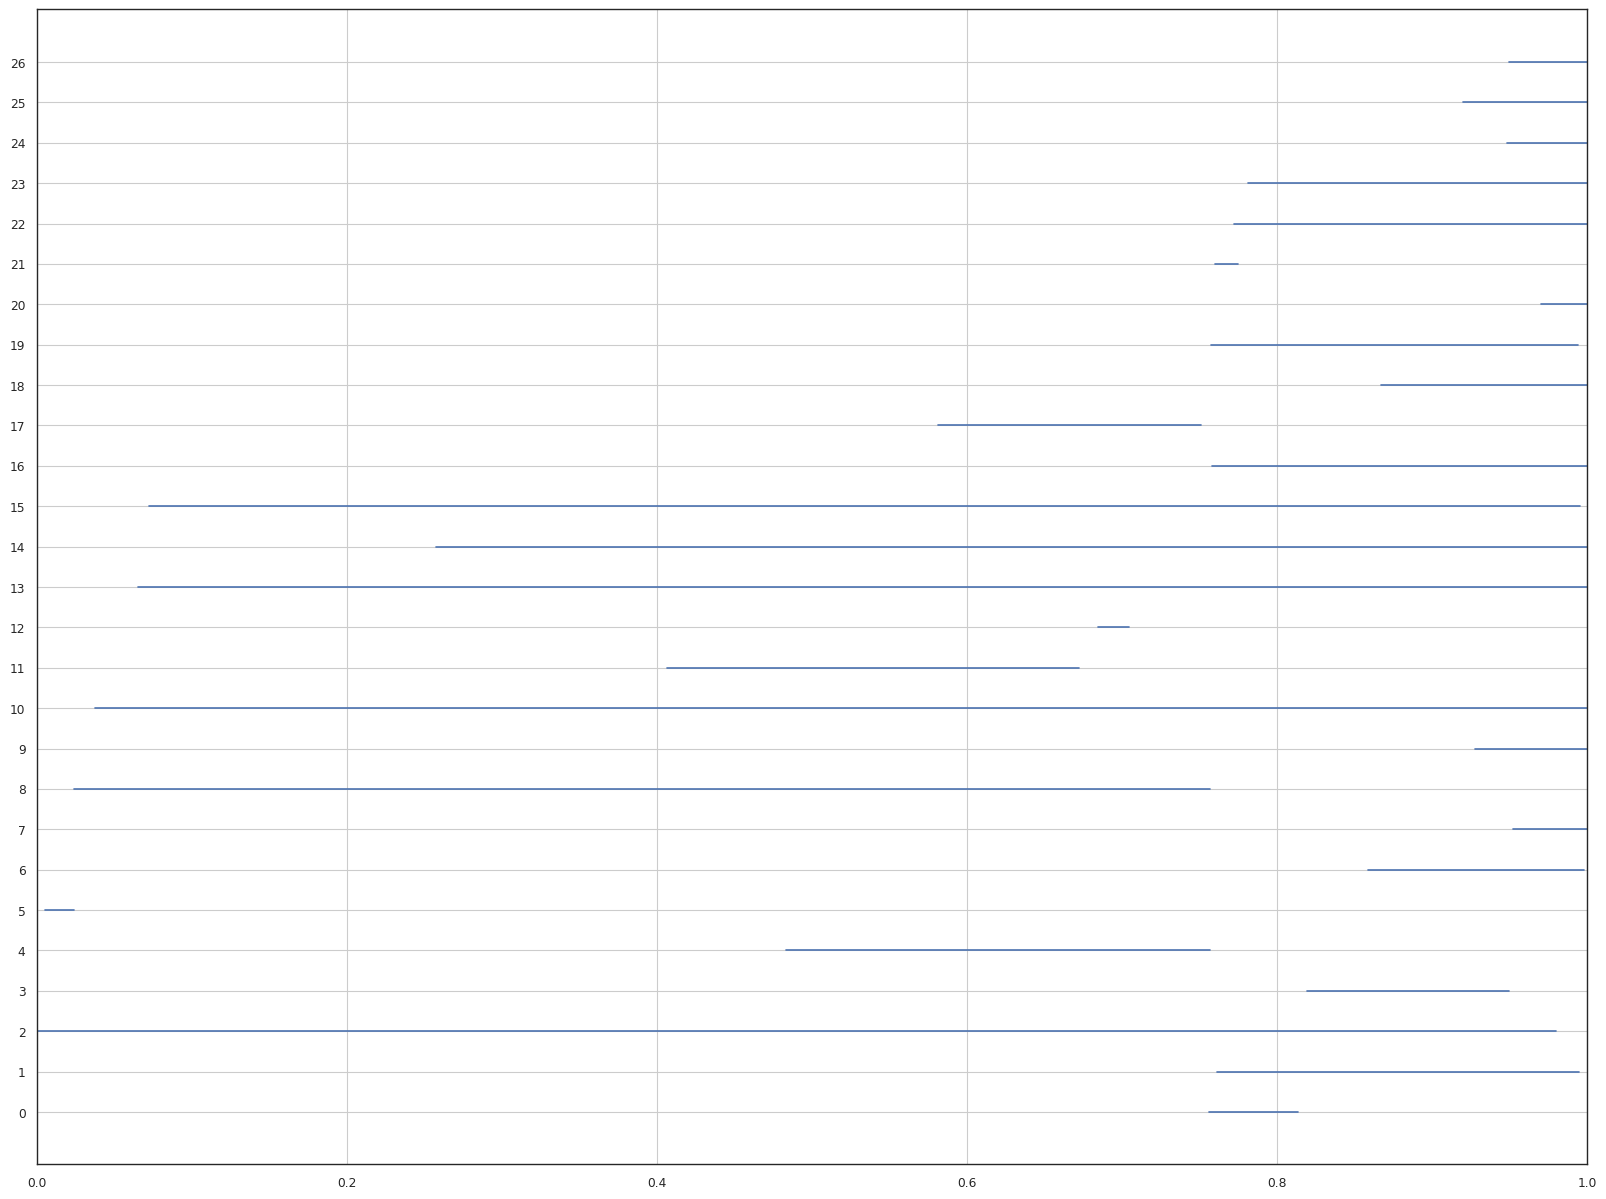

In [11]:
_ = plt.figure(figsize=(20,15))
for row_idx, row in df_id_start_stop.iterrows():
    plt.axhline(y=row_idx, xmin=row['min_idx']/total_idxs,xmax=row['max_idx']/total_idxs)
plt.yticks(range(df_id_start_stop.shape[0]), range(df_id_start_stop.shape[0]))
plt.grid() 

In [12]:
session_frames = df_tracking_new.index.values.tolist()
session_ids_covered = []
selected_frames = []
segments = []
segment_half_size = 50
for row_idx, row in df_id_start_stop.sort_values(by='total_idxs').iterrows():
    id_start, id_stop = row['min_idx'],row['max_idx']
    seg_mid = (id_start+id_stop)/2
    seg_start, seg_end = max(seg_mid-segment_half_size, 0), min(seg_mid+segment_half_size, total_idxs)
    is_id_covered = df_id_start_stop.apply(lambda row: (seg_end<=row['max_idx']) & (seg_start>=row['min_idx']),axis=1)
    seg_ids_covered = df_id_start_stop[is_id_covered]['id']
    new_ids_covered = [xr for xr in seg_ids_covered if xr not in session_ids_covered]
    if len(new_ids_covered)>0:        
        segment_frames = [xr for xr in session_frames if ((xr>=seg_start) and (xr<=seg_end))]
        selected_frames+=segment_frames
        segments.append((seg_start, seg_end, new_ids_covered, segment_frames))
        session_ids_covered+=new_ids_covered

sprint(segments)
    
    


List: segments


[
    (
        55192.0,
        55292.0,
        [0, 1, 2, 10, 13, 14, 15, 16, 21, 23],
        [
            55194,
            55197,
            55200,
            55203,
            55206,
            55209,
            55212,
            55215,
            55218,
            55221,
            55224,
            55227,
            55230,
            55233,
            55236,
            55239,
            55242,
            55245,
            55248,
            55251,
            55254,
            55257,
            55260,
            55263,
            55266,
            55269,
            55272,
            55275,
            55278,
            55281,
            55284,
            55287,
            55290
        ]
    ),
    (
        985.0,
        1085.0,
        [5],
        [
            987,
            990,
            993,
            996,
            999,
            1002,
            1005,
            1008,
            1011,
            1014,
            1017,
            1020,
            1023,
            1026,
            1029,
            1032,
            1035,
            1038,
            1041,
            1044,
            1047,
            1050,
            1053,
            1056,
            1059,
            1062,
            1065,
            1068,
            1071,
            1074,
            1077,
            1080,
            1083
        ]
    ),
    (
        49939.0,
        50039.0,
        [4, 8, 12, 17],
        [
            49941,
            49944,
            49947,
            49950,
            49953,
            49956,
            49959,
            49962,
            49965,
            49968,
            49971,
            49974,
            49977,
            49980,
            49983,
            49986,
            49989,
            49992,
            49995,
            49998,
            50001,
            50004,
            50007,
            50010,
            50013,
            50016,
            50019,
            50022,
            50025,
            50028,
            50031,
            50034,
            50037
        ]
    ),
    (
        70877.5,
        70977.5,
        [6, 7, 9, 18, 22, 24, 25, 26, 27, 29],
        [
            70878,
            70881,
            70884,
            70887,
            70890,
            70893,
            70896,
            70899,
            70902,
            70905,
            70908,
            70911,
            70914,
            70917,
            70920,
            70923,
            70926,
            70929,
            70932,
            70935,
            70938,
            70941,
            70944,
            70947,
            70950,
            70953,
            70956,
            70959,
            70962,
            70965,
            70968,
            70971,
            70974,
            70977
        ]
    ),
    (
        63629.5,
        63729.5,
        [3],
        [
            63630,
            63633,
            63636,
            63639,
            63642,
            63645,
            63648,
            63651,
            63654,
            63657,
            63660,
            63663,
            63666,
            63669,
            63672,
            63675,
            63678,
            63681,
            63684,
            63687,
            63690,
            63693,
            63696,
            63699,
            63702,
            63705,
            63708,
            63711,
            63714,
            63717,
            63720,
            63723,
            63726,
            63729
        ]
    ),
    (
        47891.5,
        47991.5,
        [11],
        [
            47892,
            47895,
            47898,
            47901,
            47904,
            47907,
            47910,
            47913,
            47916,
            47919,
            47922,
            47925,
            47928,
            47931,
            47934,
            47937,
            47940,
     

In [13]:
SOURCE_ROOT = '/home/prasoon/video_analysis/edusenseV2compute/compute/videoV3'
run_config = {
    'track_config':f'{SOURCE_ROOT}/configs/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half.py',
    'track_checkpoint':f'{SOURCE_ROOT}/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth',
    'device':'cuda:1',
}


In [14]:
# for given frame ranges get video frames and tracking results
all_frames = mmcv.VideoReader(session_video_file)

required_frame_ids = np.unique(sorted(selected_frames))
frame_data_dict = {}

for frame_idx, frame_img in enumerate(all_frames):
    if (frame_idx in required_frame_ids) & (frame_idx%3==0):
        frame_data_dict[frame_idx] = frame_img
    if frame_idx%10000==0:
        print(f"Looped {frame_idx} images")

[h264 @ 0xbce2400] error while decoding MB 175 53, bytestream -5
[h264 @ 0xbdc4280] error while decoding MB 175 53, bytestream -5
[h264 @ 0xaac5640] error while decoding MB 54 67, bytestream -11
[h264 @ 0xbdc4280] error while decoding MB 175 53, bytestream -5
[h264 @ 0xaac5640] error while decoding MB 54 67, bytestream -11


Looped 0 images


[h264 @ 0xaa0f540] error while decoding MB 36 53, bytestream -9
[h264 @ 0xaab1240] error while decoding MB 214 55, bytestream -5


Looped 10000 images


[h264 @ 0xbdc4280] error while decoding MB 92 81, bytestream -5
[h264 @ 0xab02240] error while decoding MB 50 78, bytestream -5
[h264 @ 0xab2aa40] error while decoding MB 74 72, bytestream -7


Looped 20000 images


[h264 @ 0xaa23980] error while decoding MB 160 48, bytestream -26
[h264 @ 0xaac5640] error while decoding MB 40 66, bytestream -34
[h264 @ 0xaaede40] error while decoding MB 126 57, bytestream -24
[h264 @ 0xab16640] error while decoding MB 172 44, bytestream -12
[h264 @ 0xbbd0b00] error while decoding MB 66 33, bytestream -16
[h264 @ 0xbbf9300] error while decoding MB 136 37, bytestream -29
[h264 @ 0xab42f00] error while decoding MB 39 10, bytestream -16
[h264 @ 0xbdb3380] error while decoding MB 186 8, bytestream -8
[h264 @ 0xaa23980] error while decoding MB 197 39, bytestream -6
[h264 @ 0xaac5640] error while decoding MB 196 50, bytestream -19
[h264 @ 0xaaede40] error while decoding MB 168 40, bytestream -18
[h264 @ 0xab16640] error while decoding MB 122 41, bytestream -14
[h264 @ 0xbbd0b00] error while decoding MB 138 15, bytestream -6
[h264 @ 0xbbf9300] error while decoding MB 191 53, bytestream -6
[h264 @ 0xab42f00] error while decoding MB 154 5, bytestream -10
[h264 @ 0xbdb3380] 

Looped 30000 images


[h264 @ 0xab42f00] error while decoding MB 130 93, bytestream -5
[h264 @ 0xbdb3380] error while decoding MB 22 84, bytestream -6
[h264 @ 0xaa23980] error while decoding MB 164 92, bytestream -28
[h264 @ 0xaac5640] error while decoding MB 219 103, bytestream -9
[h264 @ 0xaaede40] error while decoding MB 32 83, bytestream -16
[h264 @ 0xab16640] error while decoding MB 141 85, bytestream -12
[h264 @ 0xbbd0b00] error while decoding MB 65 83, bytestream -28
[h264 @ 0xbbf9300] error while decoding MB 198 93, bytestream -12
[h264 @ 0xab42f00] error while decoding MB 184 85, bytestream -15
[h264 @ 0xbdb3380] error while decoding MB 215 83, bytestream -40
[h264 @ 0xaa23980] error while decoding MB 82 96, bytestream -14
[h264 @ 0xaac5640] error while decoding MB 10 102, bytestream -6
[h264 @ 0xaaede40] error while decoding MB 46 91, bytestream -22
[h264 @ 0xab16640] error while decoding MB 76 92, bytestream -20
[h264 @ 0xbbd0b00] error while decoding MB 101 85, bytestream -30
[h264 @ 0xbbf9300] 

Looped 40000 images


[h264 @ 0xbbd0b00] error while decoding MB 43 82, bytestream -16
[h264 @ 0xbbf9300] error while decoding MB 147 84, bytestream -12
[h264 @ 0xab42f00] error while decoding MB 204 80, bytestream -25
[h264 @ 0xbdb3380] error while decoding MB 63 82, bytestream -15
[h264 @ 0xaa23980] error while decoding MB 20 82, bytestream -18
[h264 @ 0xaac5640] error while decoding MB 68 66, bytestream -10
[h264 @ 0xaaede40] error while decoding MB 20 66, bytestream -22
[h264 @ 0xab16640] error while decoding MB 77 77, bytestream -6
[h264 @ 0xbbd0b00] error while decoding MB 158 75, bytestream -14
[h264 @ 0xbbf9300] error while decoding MB 49 80, bytestream -18
[h264 @ 0xab42f00] error while decoding MB 78 55, bytestream -10
[h264 @ 0xbdb3380] error while decoding MB 211 68, bytestream -28
[h264 @ 0xaa23980] error while decoding MB 9 70, bytestream -8
[h264 @ 0xaac5640] error while decoding MB 220 71, bytestream -38
[h264 @ 0xaaede40] error while decoding MB 59 37, bytestream -10
[h264 @ 0xab16640] erro

Looped 50000 images


[h264 @ 0xab16640] error while decoding MB 132 63, bytestream -6
[h264 @ 0xbbd0b00] error while decoding MB 79 37, bytestream -26
[h264 @ 0xbbf9300] error while decoding MB 59 36, bytestream -28
[h264 @ 0xab42f00] error while decoding MB 135 15, bytestream -14
[h264 @ 0xbdb3380] error while decoding MB 116 21, bytestream -8
[h264 @ 0xaa23980] error while decoding MB 190 8, bytestream -8
[h264 @ 0xaac5640] error while decoding MB 215 19, bytestream -6
[h264 @ 0xaaede40] error while decoding MB 167 6, bytestream -10
[h264 @ 0xab16640] error while decoding MB 186 7, bytestream -26
[h264 @ 0xbbd0b00] error while decoding MB 43 54, bytestream -12
[h264 @ 0xbbf9300] error while decoding MB 132 46, bytestream -18
[h264 @ 0xab42f00] error while decoding MB 39 8, bytestream -12
[h264 @ 0xbdb3380] error while decoding MB 157 9, bytestream -14
[h264 @ 0xaa23980] error while decoding MB 238 64, bytestream -14
[h264 @ 0xaac5640] error while decoding MB 236 56, bytestream -12
[h264 @ 0xaaede40] erro

Looped 60000 images


[h264 @ 0xab02240] error while decoding MB 73 26, bytestream -5
[h264 @ 0xab16640] error while decoding MB 206 127, bytestream -5
[h264 @ 0xbbd0b00] error while decoding MB 213 90, bytestream -30
[h264 @ 0xbbf9300] error while decoding MB 118 86, bytestream -11
[h264 @ 0xab42f00] error while decoding MB 192 102, bytestream -8
[h264 @ 0xbdb3380] error while decoding MB 152 90, bytestream -11
[h264 @ 0xaa23980] error while decoding MB 176 92, bytestream -41
[h264 @ 0xaac5640] error while decoding MB 166 91, bytestream -6
[h264 @ 0xaaede40] error while decoding MB 184 99, bytestream -10
[h264 @ 0xab16640] error while decoding MB 195 89, bytestream -6
[h264 @ 0xbbd0b00] error while decoding MB 206 90, bytestream -16
[h264 @ 0xbbf9300] error while decoding MB 133 82, bytestream -8
[h264 @ 0xab42f00] error while decoding MB 190 89, bytestream -12
[h264 @ 0xbdb3380] error while decoding MB 195 90, bytestream -12
[h264 @ 0xaa23980] error while decoding MB 86 90, bytestream -20
[h264 @ 0xaac564

Looped 70000 images


[h264 @ 0xbdb3380] error while decoding MB 229 80, bytestream -23
[h264 @ 0xaa23980] error while decoding MB 121 82, bytestream -6
[h264 @ 0xaac5640] error while decoding MB 77 78, bytestream -28
[h264 @ 0xaaede40] error while decoding MB 221 65, bytestream -24


In [15]:
session_id_viz_dir = f'{id_viz_cache_root}/{sample_session_id}'
os.makedirs(session_id_viz_dir, exist_ok=True)
tracking_model =None
if tracking_model:
    printm("# Deleting Previous Model")
    del tracking_model
tracking_model = init_tracking_model(run_config['track_config'],
                                 run_config['track_checkpoint'],
                                 device=run_config['device'])
for seg_idx, (seg_start, seg_end, new_ids_covered, segment_frames) in enumerate(segments):
    seg_video_id = f'S{seg_idx}_{int(seg_start)}_{int(seg_end)}_{"_".join(map(str,new_ids_covered))}'
    match_cache_dir = f'{session_id_viz_dir}/{seg_video_id}'
    match_video_file = f'{session_id_viz_dir}/{seg_video_id}.mp4'
    if os.path.exists(match_video_file):
        continue
    print(match_video_file)
    os.makedirs(match_cache_dir, exist_ok=True)
    frame_num=0

    for frame_idx in segment_frames:
        frame_tracking_file = f"{session_frame_dir}/{frame_idx}.pb"
        if os.path.exists(frame_tracking_file) and (frame_idx in frame_data_dict):
            frame_file_out = os.path.join(match_cache_dir, f'{frame_num:06d}.jpg')
            frame_num+=1
            if os.path.exists(frame_file_out):
                continue
            frame_tracking_results = pickle.load(open(frame_tracking_file,"rb"))[1]
            for person_idx in range(len(frame_tracking_results)):
                old_id= int(frame_tracking_results[person_idx]['track_id'])
                frame_tracking_results[person_idx]['track_id'] =old_to_new_id_map[old_id]
            frame_img = deepcopy(frame_data_dict[frame_idx])
            if len(frame_tracking_results)>0:
                frame_tracking_results = {
                    'track_bboxes':[np.array([[xr['track_id']]+xr['bbox'].tolist() for xr in frame_tracking_results])],
                    'det_bboxes':[np.array([xr['bbox'].tolist() for xr in frame_tracking_results])]}
                frame_track_img = tracking_model.show_result(
                    frame_img,
                    frame_tracking_results,
                    thickness=5,
                    font_scale=.5,
                    score_thr=0.1,
                    show=False,
                    wait_time=int(1000. / 5),
                    out_file=frame_file_out,
                    backend='cv2')
            else:
                cv2.imwrite(frame_file_out,frame_img)
    
    #         break
    # break
    mmcv.frames2video(match_cache_dir, match_video_file, fps=5, fourcc='mp4v')
    print(f"Done for segment {seg_video_id}")
    # break
    
    

2023-09-03 21:34:57,339 - mmdet - INFO - image shape: height=800, width=1440 in YOLOX.__init__
2023-09-03 21:34:57,536 - mmtrack - INFO - initialize YOLOX with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth'}
2023-09-03 21:34:57,537 - mmcv - INFO - load model from: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-09-03 21:34:57,538 - mmcv - INFO - load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-09-03 21:34:58,234 - mmcv - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([80, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 320, 1, 

load checkpoint from local path: /home/prasoon/video_analysis/edusenseV2compute/compute/videoV3/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector